## Imports

In [12]:
from scipy.stats import gaussian_kde
import numpy as np
from datetime import datetime, timedelta

import matplotlib
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6


import matplotlib.pyplot as plt
# plt.style.use('ggplot')

import pandas as pd

## Data Analysis

Before fitting prediction models, let us look into the data we have.

In [13]:
births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
births_2000s_df_with_index = births_2000s_df\
    .rename(columns={'date_of_month': 'day'})\
    .set_index(pd.to_datetime(
        births_2000s_df.rename(columns={'date_of_month': 'day'})
        [['year', 'month', 'day']]))\
    .assign(weekday_name=lambda df: df.index.weekday_name)\
    .assign(day_of_year=lambda df: df.index.dayofyear)\
    .assign(week_of_year=lambda df: df.index.weekofyear)
births_2000s_df_with_index.tail()

,year,month,day,day_of_week,births,weekday_name,day_of_year,week_of_year
2014-12-27,2014,12,27,6,8656,Saturday,361,52
2014-12-28,2014,12,28,7,7724,Sunday,362,52
2014-12-29,2014,12,29,1,12811,Monday,363,1
2014-12-30,2014,12,30,2,13634,Tuesday,364,1
2014-12-31,2014,12,31,3,11990,Wednesday,365,1


We assert that no data imputation is needed.

In [14]:
def num_days_in_year(year):
    return (datetime(year, 12, 31) - datetime(year, 1, 1)).days + 1


def missing_days(df):
    return births_2000s_df_with_index.groupby('year').births.describe()\
        .assign(expected_days=lambda df: list(map(num_days_in_year, df.index)))\
        .assign(missing=lambda df: df.expected_days - df['count'])

        
assert not any(missing_days(births_2000s_df_with_index).missing)

### Some Statistics

We next show how births distribute in each year, month, and day of week. We see that whereas the data follows a somewhat steady mean and std. dev. over years and over months, there are is much more variability between days of week:
1. There are numerous outliers in each day of week.
2. There are significantly _less_ births during the weekend (Saturday-Sunday) than during the work week (Monday-Friday).
3. Weekend days have lower variance than work days.

In [15]:
# def show_mean_and_std_by_time_dimension(time_dimension):
#     births_2000s_df_with_index.groupby(time_dimension).births.describe()[['mean', 'std']].plot.bar(fontsize=14)

# list(map(show_mean_and_std_by_time_dimension, ['weekday_name', 'year', 'month']));

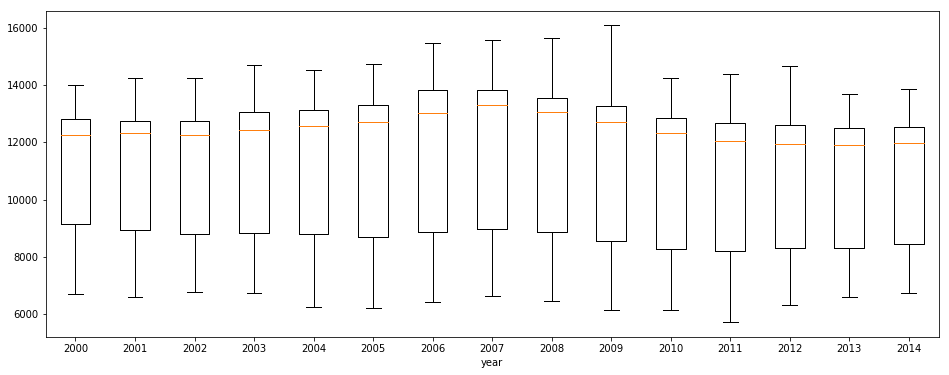

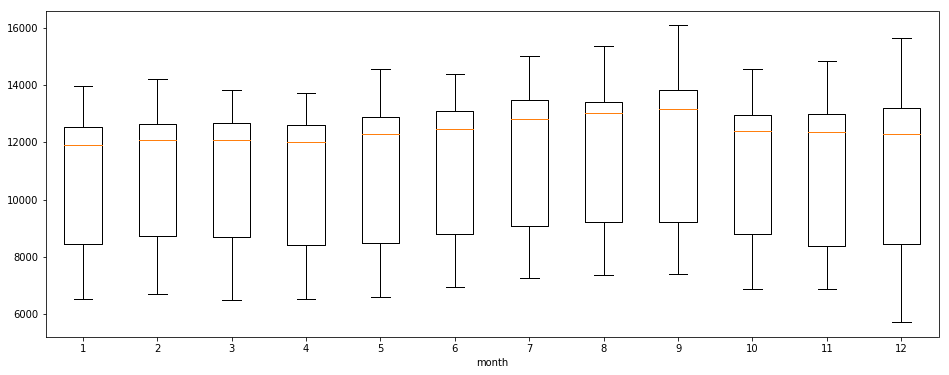

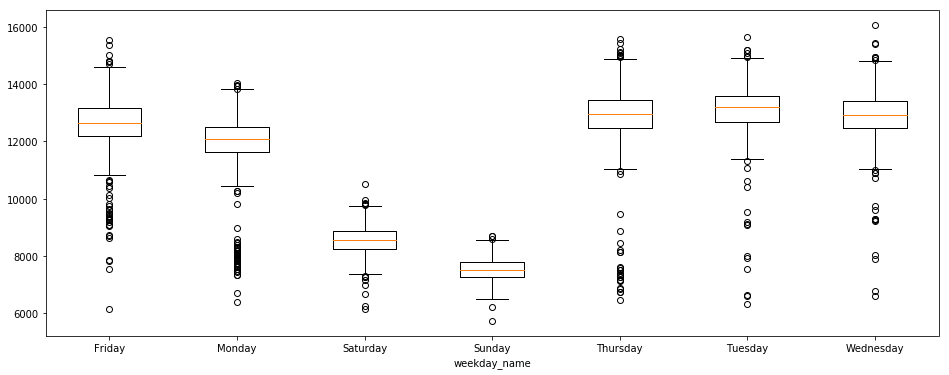

In [16]:
def boxplots(df, time_dimension):
    fig, ax = plt.subplots(1, 1)
    x = sorted(df[time_dimension].unique())
    ax.boxplot([list(df[df[time_dimension] == t].births) for t in x])
    ax.set_xticklabels(x)
    ax.set_xlabel(df[time_dimension].name)

    
for time_dimension in ('year', 'month', 'weekday_name'):
    boxplots(births_2000s_df_with_index, time_dimension)

We also take a look at the distribution of all data points, regardless of time. The distribution is markedly bimodal: one mode for weekend, the other for rest of week. In fact, the weekend distribution is bimodal too, because of differences between Saturday and Sunday.

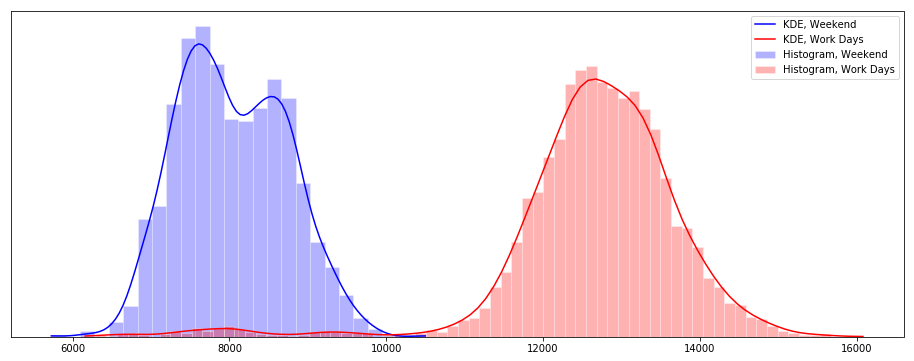

In [17]:
def density_estimation(df):
    fig, ax = plt.subplots(1, 1)
    births_weekend = df.births[df.day_of_week >= 6]
    births_work_days = df.births[df.day_of_week < 6]
    
    ax.hist(births_weekend, bins='auto', facecolor='blue', edgecolor='white', 
            normed=True, label="Histogram, Weekend", alpha=0.3)
    ax.hist(births_work_days, bins='auto', facecolor='red', edgecolor='white', 
            normed=True, label="Histogram, Work Days", alpha=0.3)

    x_kde_weekend = np.linspace(births_weekend.min(), births_weekend.max(), 100)
    ax.plot(x_kde_weekend, gaussian_kde(births_weekend)(x_kde_weekend),
            label="KDE, Weekend", color='blue')

    x_kde_work_days = np.linspace(births_work_days.min(), births_work_days.max(), 100)
    ax.plot(x_kde_work_days, gaussian_kde(births_work_days)(x_kde_work_days), label="KDE, Work Days", color='red')
    
    ax.get_yaxis().set_visible(False)
    ax.legend()
    
density_estimation(births_2000s_df_with_index)

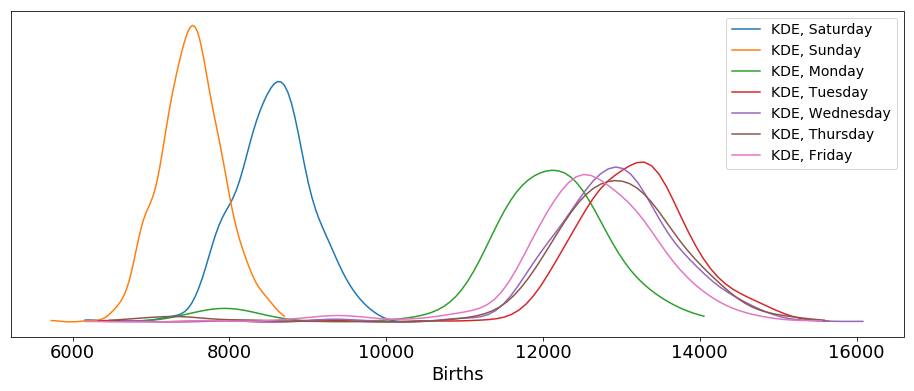

In [82]:
def density_estimation_by_weekday(df):
    fig, ax = plt.subplots(1, 1)
    for d in df.weekday_name.unique():
        daily_births = df.births[df.weekday_name == d]
        x_kde = np.linspace(daily_births.min(), daily_births.max(), 100)
        ax.plot(x_kde, gaussian_kde(daily_births)(x_kde),label="KDE, %s" % d)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Births")
    ax.legend(fontsize=14)
    
density_estimation_by_weekday(births_2000s_df_with_index)

## Model Ideas

### Disregarding Time Series
The last plot shows that for each weekday, the data distribution resembles a Gaussian. We should thus try several models:
1. Searate Model: for each weekday $d_i, i=1..7$, let the prior be $d_i \sim \mathcal{N}(\mu_i, \sigma_i^2)$, where $\mu_i$ and  $\sigma_i$ are chosen independently of other days, e.g. drawn from a Gaussian which is parameterized on the sample mean and sample variance for  $d_i$.
2. Hierarchical Model: similar to Separate Model, except that all $\mu_i$ and all $\sigma_i$ are each drawn from a shared distribution.
3. Hierarchicial Model for work days, Separate Models for weekend days.

### Using the Time Series


## Seasonality
The next few plots are meant to emphasize any obvious seasonality in the time series of births.

First, we see that each year displays are generally similar trend: steady increase in first few months, followed by a peak, a drop, and another peak at end of year.

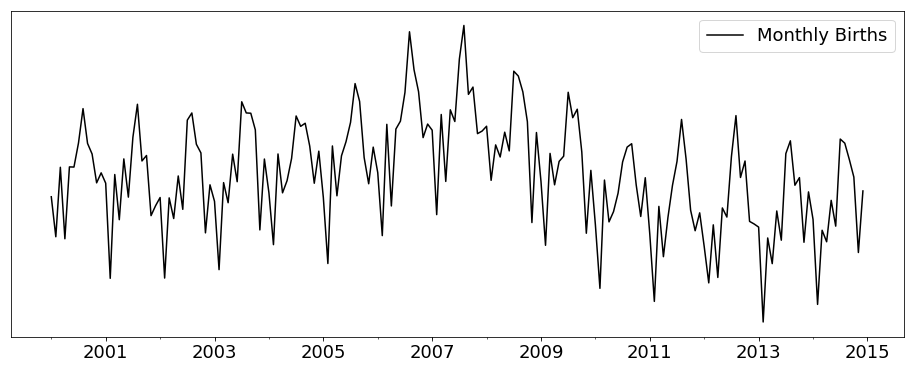

In [163]:
d = births_2000s_df_with_index.groupby(('year', 'month')).births.sum().reset_index()
f = pd.to_datetime(d.assign(day=1).drop('births', axis=1))
ax = d.set_index(f).drop(['year', 'month'], axis=1).births.rename("Monthly Births").plot(color="black")
ax.legend()
ax.get_yaxis().set_visible(False)

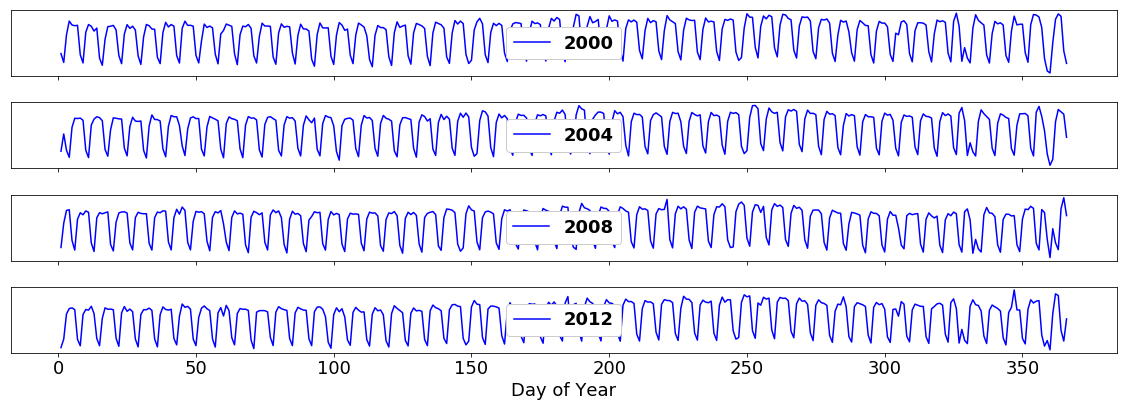

In [161]:
def compare_some_years(years):
    matplotlib.rc('font', **{'size': 18})
    fix, axes = plt.subplots(len(years), 1, sharex=True)
    for i, year in enumerate(years):
        axes[i].plot(
            births_2000s_df_with_index.set_index('day_of_year')[lambda r: r.year == year].births, 
            label=year, color='blue')
        axes[i].legend(prop={'weight':'bold'}, loc='center', framealpha=1)
        axes[i].get_yaxis().set_visible(False)
    axes[-1].set_xlabel("Day of Year")
    plt.tight_layout()
        
compare_some_years(range(2000, 2015, 4))